In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 1.0  # final time
rA = 1.5   # maximum interaction distance

seed=17

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a': 7.51}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [4]:
force_names = ['cubic', 'pw. quad.', 'GLS']
solver_names = ['EF', 'EB']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.'}

In [5]:
models_ef = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), ef.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), ef.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), ef.solve_ivp, 1)}
models_eb = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), eb.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), eb.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), eb.solve_ivp, 1)}
model_dicts = {'EF': models_ef, 'EB': models_eb}

In [6]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=True), cl.Cell(1, [0.3], proliferating=True)]

In [7]:
t_data_ref = np.linspace(0,1, 10000+1)
ref_sol_dicts = {}
for solver in solver_names:
    models = model_dicts[solver]
    ref_sols = {}
    for force in force_names: 
        #params_solver = {'EF':{'dt': 0.0001}, 'EB': {'dt': 0.0001, 'jacobian': models[force].jacobian}}
        params_solver = {'EF':{'dt': 0.0001}, 'EB': {'dt': 0.0001}}
        history = models[force].simulate(cell_list, t_data_ref, params[force], params_solver[solver], seed=seed)
        ref_sols[force] = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])[:len(t_data_ref)]
    ref_sol_dicts[solver] = ref_sols

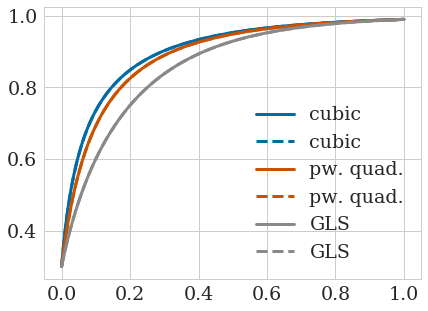

In [8]:
# plot the reference solution
for force in force_names:
    plt.plot(t_data_ref, ref_sol_dicts['EF'][force], label=force, color=colors[force])
    plt.plot(t_data_ref, ref_sol_dicts['EB'][force], label=force, linestyle='--', color=colors[force])
plt.legend()

In [25]:
dt_values = [0.001*1.25**n for n in range(0, 28)]

In [26]:
sol_dicts = {}

In [27]:
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        history = model_dicts['EF'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts['EF'][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts['EF'] = sol

[1001, 0.001]
[801, 0.00125]
[641, 0.0015625]
[513, 0.001953125]
[410, 0.00244140625]
[328, 0.0030517578125]
[263, 0.003814697265625]
[210, 0.00476837158203125]
[168, 0.0059604644775390625]
[135, 0.007450580596923828]
[108, 0.009313225746154785]
[86, 0.011641532182693481]
[69, 0.014551915228366852]
[55, 0.018189894035458565]
[44, 0.022737367544323206]
[36, 0.028421709430404007]
[29, 0.03552713678800501]
[23, 0.04440892098500626]
[19, 0.05551115123125783]
[15, 0.06938893903907228]
[12, 0.08673617379884035]
[10, 0.10842021724855044]
[8, 0.13552527156068805]
[6, 0.16940658945086007]
[5, 0.21175823681357508]
[4, 0.2646977960169689]
[4, 0.3308722450212111]
[3, 0.41359030627651383]


In [45]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force]) > 0.01)[0][0]]])

['cubic', 0.011641532182693481]
['pw. quad.', 0.014551915228366852]
['GLS', 0.018189894035458565]


In [46]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force]) > 0.1)[0][0]]])

['cubic', 0.06938893903907228]
['pw. quad.', 0.08673617379884035]
['GLS', 0.13552527156068805]


In [28]:
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        history = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts['EB'][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts['EB'] = sol

[1001, 0.001]
[801, 0.00125]
[641, 0.0015625]
[513, 0.001953125]
[410, 0.00244140625]
[328, 0.0030517578125]
[263, 0.003814697265625]
[210, 0.00476837158203125]
[168, 0.0059604644775390625]
[135, 0.007450580596923828]
[108, 0.009313225746154785]
[86, 0.011641532182693481]
[69, 0.014551915228366852]
[55, 0.018189894035458565]
[44, 0.022737367544323206]
[36, 0.028421709430404007]
[29, 0.03552713678800501]
[23, 0.04440892098500626]
[19, 0.05551115123125783]
[15, 0.06938893903907228]
[12, 0.08673617379884035]
[10, 0.10842021724855044]
[8, 0.13552527156068805]
[6, 0.16940658945086007]
[5, 0.21175823681357508]
[4, 0.2646977960169689]
[4, 0.3308722450212111]
[3, 0.41359030627651383]


In [47]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force]) > 0.01)[0][0]]])

['cubic', 0.014551915228366852]
['pw. quad.', 0.018189894035458565]
['GLS', 0.018189894035458565]


In [48]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force]) > 0.1)[0][0]]])

['cubic', 0.16940658945086007]
['pw. quad.', 0.21175823681357508]
['GLS', 0.2646977960169689]


In [49]:
dt_values

[0.001,
 0.00125,
 0.0015625,
 0.001953125,
 0.00244140625,
 0.0030517578125,
 0.003814697265625,
 0.00476837158203125,
 0.0059604644775390625,
 0.007450580596923828,
 0.009313225746154785,
 0.011641532182693481,
 0.014551915228366852,
 0.018189894035458565,
 0.022737367544323206,
 0.028421709430404007,
 0.03552713678800501,
 0.04440892098500626,
 0.05551115123125783,
 0.06938893903907228,
 0.08673617379884035,
 0.10842021724855044,
 0.13552527156068805,
 0.16940658945086007,
 0.21175823681357508,
 0.2646977960169689,
 0.3308722450212111,
 0.41359030627651383]

In [51]:
sol_dicts['EF']['GLS']

[0.0005190345280774161,
 0.0006635424817409862,
 0.0008443882851771994,
 0.0010707726427744728,
 0.0013542785644750836,
 0.001709457632806894,
 0.002154737982972656,
 0.002713314245958567,
 0.0034147905062083144,
 0.0042969195862180756,
 0.005407804153108714,
 0.006809657981921602,
 0.008584480494804682,
 0.010838992691481981,
 0.013718705363389393,
 0.01742451443772777,
 0.02223472871608378,
 0.028559850071016673,
 0.037019672391881926,
 0.048559648142035367,
 0.06466741615873473,
 0.08767067748687132,
 0.12116273360835451,
 0.18234497901534252,
 0.35816908407217973,
 0.6317160003915786,
 0.9100536786182504,
 1.2343888599925945]

Text(0.0025, 25, 'Backward Euler method')

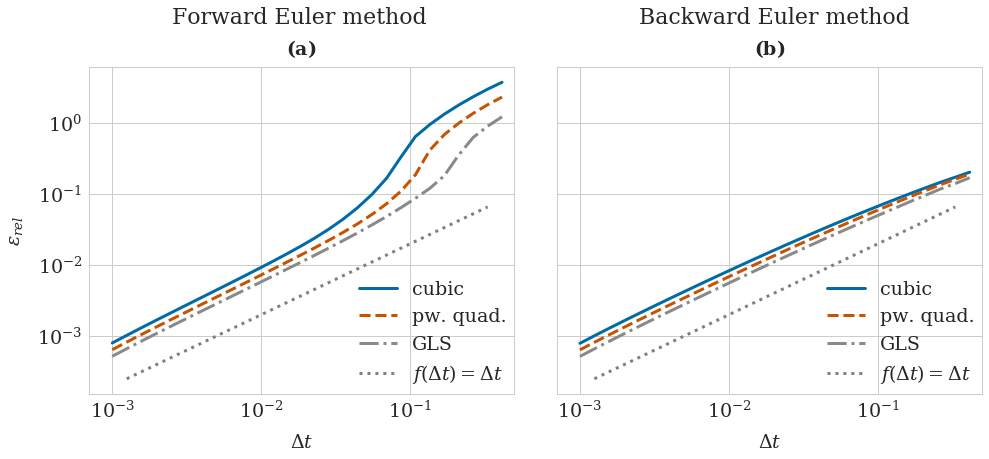

In [44]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), sharey=True, gridspec_kw={'wspace': 0.1})

# ax1
for force in force_names: 
    ax1.loglog(dt_values, sol_dicts['EF'][force], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,1], label=force+' y')
ax1.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax1.legend(loc='lower right', borderaxespad=0.)
#plt.legend()
ax1.set(xlabel='$\Delta t$')
ax1.set_title(r'$\bf{(a)}$')
ax1.set(ylabel='$\epsilon_{rel}$')
ax1.set_xlim([7*1e-4, 5*1e-1])
#ax1.set_ylim([5*1e-10, 10*1e-0])
#ax1.set_xticklabels([])
#ax1.set_ylim([5*1e-8, 5*1e-0])
ax1.text(0.0025, 25, 'Forward Euler method', fontsize=22)
#ax1.text(0.0001, 0.000001, 'Relaxation', fontsize=22, rotation='vertical')


#ax2
for force in force_names: 
    ax2.loglog(dt_values, sol_dicts['EB'][force], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
ax2.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax2.legend(loc='lower right',borderaxespad=0.)
ax2.set(xlabel='$\Delta t$')
ax2.set_xlim([7*1e-4, 5*1e-1])
ax2.set_title(r'$\bf{(b)}$')
#ax2.set_xticklabels([])

ax2.text(0.0025, 25, 'Backward Euler method', fontsize=22)

Let's pick dt = 0.2 for EB

In [75]:
force = 'GLS'
dt = 0.22
t_data = np.arange(0,1,dt)

In [62]:
%%time
history = models_ef[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)

CPU times: user 1.04 ms, sys: 55 µs, total: 1.09 ms
Wall time: 1.25 ms


In [76]:
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': models_eb[force].jacobian, 'eps': 0.00001}, seed=seed)
y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
length = min(len(t_data), len(y))
inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
ref = np.squeeze(ref_sol_dicts['EB'][force])
error_eb = np.linalg.norm(inter-ref)/np.linalg.norm(ref)

In [77]:
error_eb

0.10066421665037105

In [78]:
%%time
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': models_eb[force].jacobian}, seed=seed)


CPU times: user 18.2 ms, sys: 0 ns, total: 18.2 ms
Wall time: 38 ms


In [79]:
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
length = min(len(t_data), len(y))
inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
ref = np.squeeze(ref_sol_dicts['EB'][force])
error_eb_no_jac = np.linalg.norm(inter-ref)/np.linalg.norm(ref)

In [80]:
error_eb_no_jac

0.10066429181759787

In [81]:
%%time
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)


CPU times: user 9 ms, sys: 0 ns, total: 9 ms
Wall time: 20.5 ms


And dt=0.1 for EF

In [82]:
dt = 0.12
t_data = np.arange(0,1,dt)

In [83]:
history = models_ef[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
length = min(len(t_data), len(y))
inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
ref = np.squeeze(ref_sol_dicts['EF'][force]) ms
error_ef = np.linalg.norm(inter-ref)/np.linalg.norm(ref)

In [84]:
error_ef

0.10132356668494882

In [86]:
%%time
history = models_ef[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)

CPU times: user 1.43 ms, sys: 77 µs, total: 1.51 ms
Wall time: 3.87 ms


In [85]:
y.shape

(9, 1)

In [16]:
y[-1]

array([0.99023541])

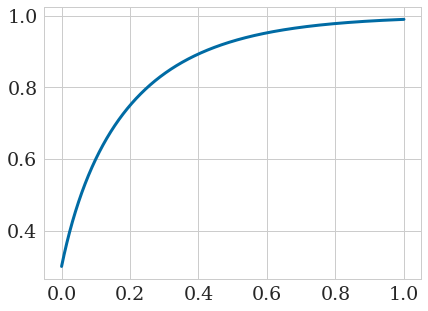

In [17]:
plt.plot(np.cumsum(dt*np.ones(10001)), y)